# **Node Classification with Graph Neural Networks**

In this notebook, we will learn to apply **Graph Neural Networks (GNNs)** to the task of node classification.

The objective of this task is to differentiate the nodes by classifying them into 7 different categories.

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.xlabel('T-SNE component 1')
    plt.yticks([])
    plt.ylabel('T-SNE component 2')

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.title('2-dimension representation using T-SNE dimension reduction tool')
    plt.show()

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# **Dataset**

To demonstrate, we make use of the Cora dataset, which is a citation network where nodes represent documents. Each node is described by a 1433-dimensional bag-of-words feature vector. Two documents are connected if there exists a citation link between them. The task is to infer the category of each document (7 in total).


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


# **Model implementation**
First, we will implement the model using the PyTorch Geometric library.

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

To recap, the **GCN layer** is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


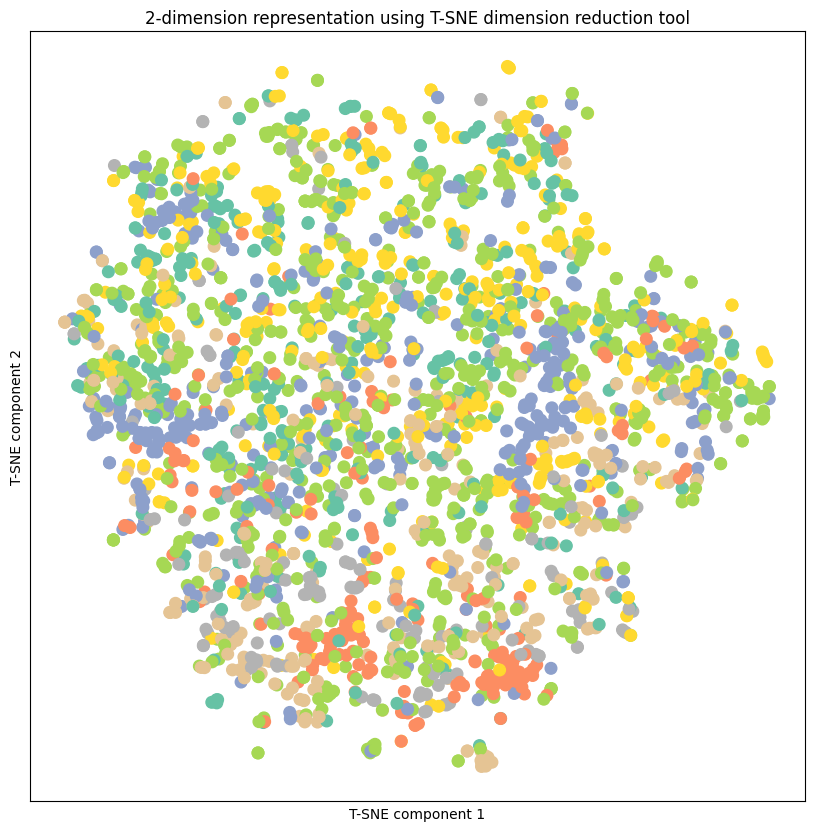

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

loss_list = []
acc_list = []
for epoch in range(1, 101):
    loss = train()
    acc = test()
    loss_list.append(loss.detach().item())
    acc_list.append(acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9457
Epoch: 002, Loss: 1.9414
Epoch: 003, Loss: 1.9340
Epoch: 004, Loss: 1.9248
Epoch: 005, Loss: 1.9121
Epoch: 006, Loss: 1.9059
Epoch: 007, Loss: 1.8949
Epoch: 008, Loss: 1.8827
Epoch: 009, Loss: 1.8717
Epoch: 010, Loss: 1.8614
Epoch: 011, Loss: 1.8517
Epoch: 012, Loss: 1.8296
Epoch: 013, Loss: 1.8275
Epoch: 014, Loss: 1.8078
Epoch: 015, Loss: 1.7991
Epoch: 016, Loss: 1.7840
Epoch: 017, Loss: 1.7628
Epoch: 018, Loss: 1.7484
Epoch: 019, Loss: 1.7325
Epoch: 020, Loss: 1.7170
Epoch: 021, Loss: 1.6988
Epoch: 022, Loss: 1.6884
Epoch: 023, Loss: 1.6784
Epoch: 024, Loss: 1.6547
Epoch: 025, Loss: 1.6187
Epoch: 026, Loss: 1.6123
Epoch: 027, Loss: 1.6032
Epoch: 028, Loss: 1.5843
Epoch: 029, Loss: 1.5617
Epoch: 030, Loss: 1.5547
Epoch: 031, Loss: 1.5179
Epoch: 032, Loss: 1.5030
Epoch: 033, Loss: 1.4777
Epoch: 034, Loss: 1.4568
Epoch: 035, Loss: 1.4447
Epoch: 036, Loss: 1.4375
Epoch: 037, Loss: 1.4218
Epoch: 038, Loss: 1.3863
Epoch: 039, Loss: 1.3499
Epoch: 040, Loss: 1.3455


Test Accuracy: 0.7810


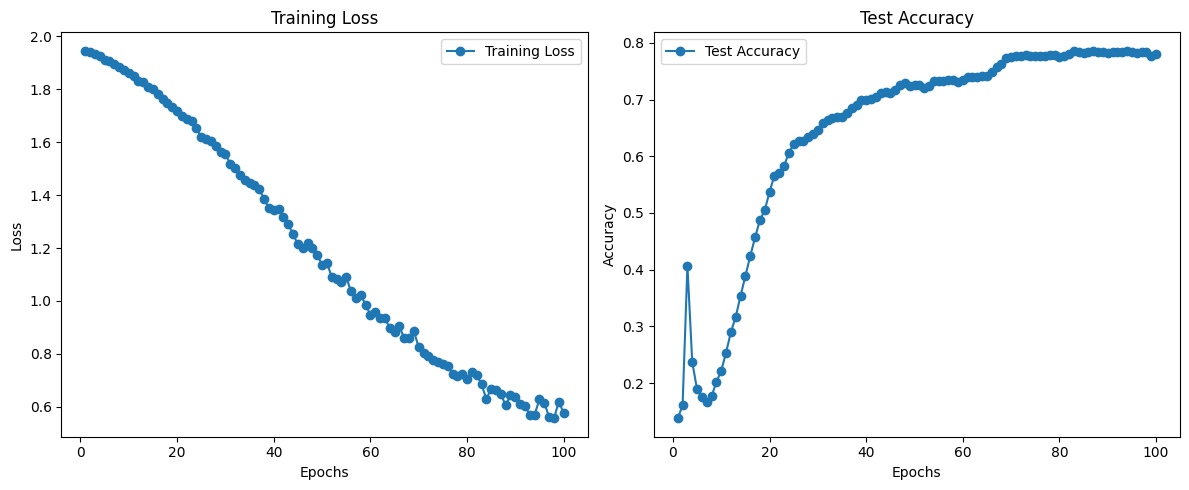

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


def plot_curves(loss_list, acc_list):
    epochs = range(1, len(loss_list) + 1)

    # Plotting loss curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_list, '-o', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_list, '-o', label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(loss_list, acc_list)


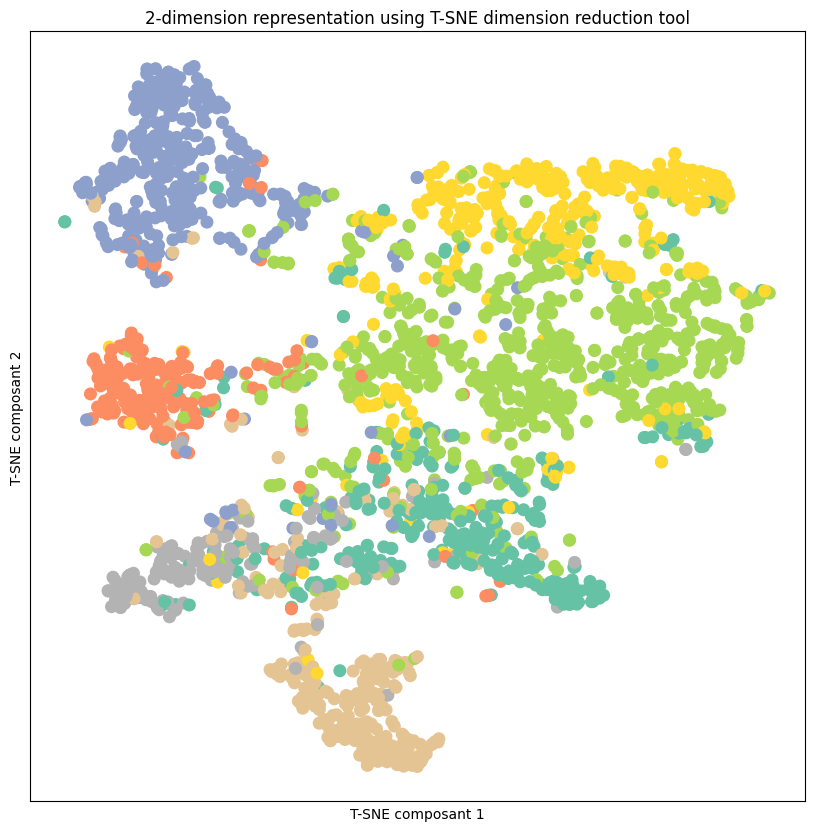

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)